<a href="https://colab.research.google.com/github/Sha-ziya/predict/blob/main/deepqnetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance gym numpy matplotlib torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
# %%
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import gym
from gym import spaces

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

/tmp/ipython-input-4-4071541446.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


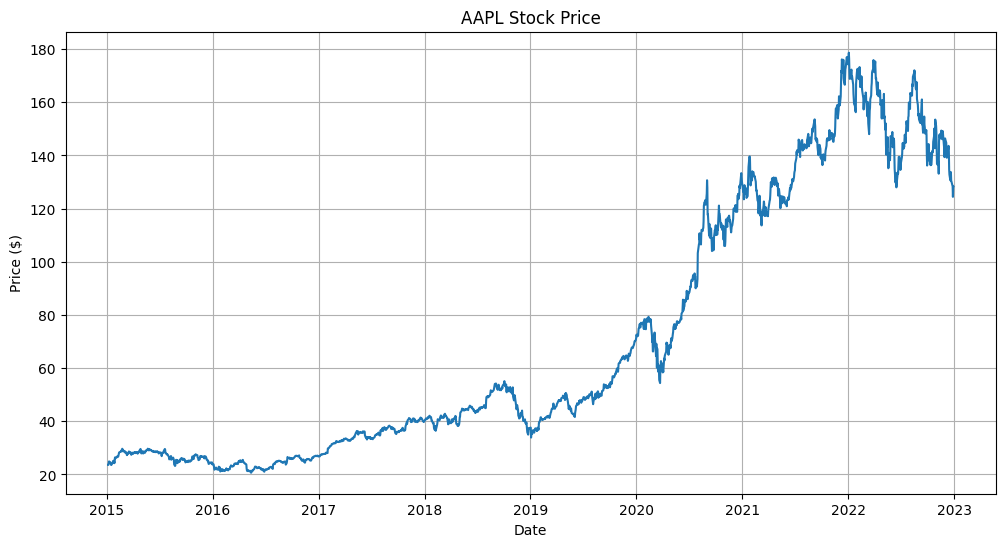

In [ ]:
# %% [markdown]
# ## 1. Data Preparation
#
# We'll download historical stock data using Yahoo Finance API.

# %%
def download_data(ticker, start_date, end_date):
    """Download stock data from Yahoo Finance"""
    data = yf.download(ticker, start=start_date, end=end_date)
    data = data[['Close']]  # We'll use adjusted close prices, which are now in 'Close'
    data.columns = ['price']  # Rename column
    data['return'] = np.log(data['price'] / data['price'].shift(1))  # Log returns
    return data.dropna()

# Download Apple stock data
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2023-01-01'
stock_data = download_data(ticker, start_date, end_date)

# Plot the price data
plt.figure(figsize=(12, 6))
plt.plot(stock_data['price'])
plt.title(f'{ticker} Stock Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid()
plt.show()

In [ ]:
# %% [markdown]
# ## 2. Trading Environment
#
# We'll create a custom OpenAI Gym environment for our trading problem.

# %%
class TradingEnv(gym.Env):
    """Custom Trading Environment that follows gym interface"""

    def __init__(self, data, initial_balance=10000, window_size=10):
        super(TradingEnv, self).__init__()

        self.data = data
        self.price_data = data['price'].values
        self.return_data = data['return'].values
        self.window_size = window_size
        self.initial_balance = initial_balance
        self.current_step = window_size - 1  # Start after we have enough history

        # Actions: 0=hold, 1=buy, 2=sell
        self.action_space = spaces.Discrete(3)

        # Observation space: past prices, returns, and current position
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(window_size * 2 + 1,),  # window_size prices + window_size returns + position
            dtype=np.float32)

        self.reset()

    def reset(self):
        """Reset the environment to initial state"""
        self.balance = self.initial_balance
        self.shares_held = 0
        self.current_step = self.window_size - 1
        self.total_value = self.balance
        self.position = 0  # 0=no position, 1=long

        # Return the initial observation
        return self._next_observation()

    def _next_observation(self):
        """Get the next observation from the data"""
        # Get the window of prices and returns
        prices = self.price_data[self.current_step - self.window_size + 1:self.current_step + 1]
        returns = self.return_data[self.current_step - self.window_size + 1:self.current_step + 1]

        # Normalize the prices to be relative to the first price in the window
        norm_prices = prices / prices[0] - 1

        # Create the observation vector
        obs = np.concatenate([
            norm_prices,
            returns,
            [self.position]
        ])

        return obs

    def step(self, action):
        """Execute one step in the environment"""
        assert self.action_space.contains(action), "Invalid action"

        # Get the current price
        current_price = self.price_data[self.current_step]
        prev_value = self.total_value

        # Execute the action
        if action == 1:  # Buy
            # Buy as many shares as we can with current balance
            shares_bought = self.balance // current_price
            cost = shares_bought * current_price
            self.shares_held += shares_bought
            self.balance -= cost
            self.position = 1
        elif action == 2:  # Sell
            # Sell all shares we hold
            sale_value = self.shares_held * current_price
            self.balance += sale_value
            self.shares_held = 0
            self.position = 0

        # Calculate the new total portfolio value
        self.total_value = self.balance + self.shares_held * current_price

        # Move to the next time step
        self.current_step += 1

        # Check if we've reached the end of the data
        done = self.current_step >= len(self.price_data) - 1

        # Calculate reward as the change in portfolio value
        reward = self.total_value - prev_value

        # Get the next observation
        obs = self._next_observation()

        return obs, reward, done, {'current_value': self.total_value}

    def render(self, mode='human'):
        """Render the environment (print current state)"""
        current_price = self.price_data[self.current_step]
        print(f'Step: {self.current_step}')
        print(f'Price: {current_price:.2f}')
        print(f'Shares held: {self.shares_held}')
        print(f'Cash: {self.balance:.2f}')
        print(f'Total value: {self.total_value:.2f}')
        print('---')

In [ ]:
# %% [markdown]
# ## 3. Deep Q-Network (DQN) Implementation
#
# We'll implement a DQN agent with experience replay and target network.

# %%
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)  # Experience replay buffer
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.batch_size = 32

        # Main network
        self.model = self._build_model()

        # Target network (for stability)
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        """Build the neural network for Q-value approximation"""
        model = nn.Sequential(
            nn.Linear(self.state_size, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, self.action_size)
        )
        return model

    def update_target_model(self):
        """Copy weights from main network to target network"""
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay memory"""
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """Select action using epsilon-greedy policy"""
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)

        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values).item()

    def replay(self):
        """Train on a batch of experiences from memory"""
        if len(self.memory) < self.batch_size:
            return

        # Sample a minibatch from memory
        minibatch = random.sample(self.memory, self.batch_size)

        states = torch.FloatTensor(np.array([t[0] for t in minibatch]))
        actions = torch.LongTensor(np.array([t[1] for t in minibatch]))
        rewards = torch.FloatTensor(np.array([t[2] for t in minibatch]))
        next_states = torch.FloatTensor(np.array([t[3] for t in minibatch]))
        dones = torch.FloatTensor(np.array([t[4] for t in minibatch]))

        # Current Q values
        current_q = self.model(states).gather(1, actions.unsqueeze(1))

        # Next Q values from target network
        next_q = self.target_model(next_states).max(1)[0].detach()
        target_q = rewards + (1 - dones) * self.gamma * next_q

        # Compute loss and update weights
        criterion = nn.MSELoss()
        loss = criterion(current_q.squeeze(), target_q)

        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def save(self, path):
        """Save model weights"""
        torch.save(self.model.state_dict(), path)

    def load(self, path):
        """Load model weights"""
        self.model.load_state_dict(torch.load(path))


Episode: 1/50, Portfolio Value: $36756.94, Epsilon: 0.01
Episode: 2/50, Portfolio Value: $16565.29, Epsilon: 0.01
Episode: 3/50, Portfolio Value: $11412.37, Epsilon: 0.01
Episode: 4/50, Portfolio Value: $10724.73, Epsilon: 0.01
Episode: 5/50, Portfolio Value: $10792.36, Epsilon: 0.01
Episode: 6/50, Portfolio Value: $12130.90, Epsilon: 0.01
Episode: 7/50, Portfolio Value: $14518.70, Epsilon: 0.01
Episode: 8/50, Portfolio Value: $8840.83, Epsilon: 0.01
Episode: 9/50, Portfolio Value: $9112.24, Epsilon: 0.01
Episode: 10/50, Portfolio Value: $30849.28, Epsilon: 0.01
Episode: 11/50, Portfolio Value: $10131.55, Epsilon: 0.01
Episode: 12/50, Portfolio Value: $9429.65, Epsilon: 0.01
Episode: 13/50, Portfolio Value: $10138.69, Epsilon: 0.01
Episode: 14/50, Portfolio Value: $15077.52, Epsilon: 0.01
Episode: 15/50, Portfolio Value: $21218.88, Epsilon: 0.01
Episode: 16/50, Portfolio Value: $12290.17, Epsilon: 0.01
Episode: 17/50, Portfolio Value: $61756.87, Epsilon: 0.01
Episode: 18/50, Portfolio 

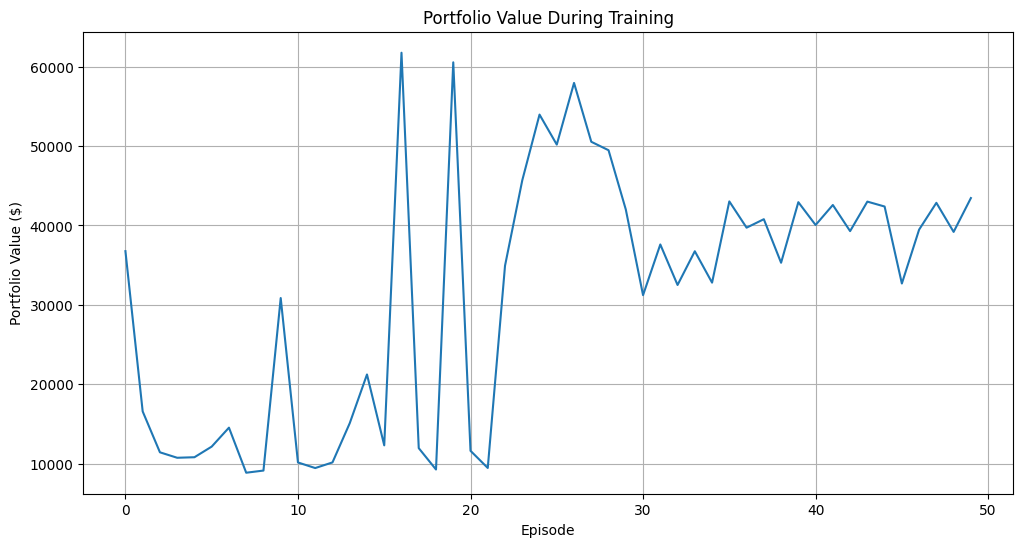

In [ ]:
# %% [markdown]
# ## 4. Training the DQN Agent
#
# Now we'll train our agent on the stock data.

# %%
# Prepare the environment
window_size = 10
env = TradingEnv(stock_data, window_size=window_size)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initialize the agent
agent = DQNAgent(state_size, action_size)

# Training parameters
episodes = 50  # Number of episodes to train
portfolio_values = []  # To track performance over episodes

# %%
# Training loop
for e in range(episodes):
    state = env.reset()
    state = np.reshape(state, [state_size])

    total_reward = 0
    done = False

    while not done:
        # Select action
        action = agent.act(state)

        # Execute action in environment
        next_state, reward, done, info = env.step(action)
        next_state = np.reshape(next_state, [state_size])

        # Store experience in replay memory
        agent.remember(state, action, reward, next_state, done)

        state = next_state
        total_reward += reward

        # Train the agent on past experiences
        agent.replay()

    # Update target network every episode
    agent.update_target_model()

    # Track portfolio value at end of episode
    portfolio_values.append(info['current_value'])

    print(f"Episode: {e + 1}/{episodes}, Portfolio Value: ${info['current_value']:.2f}, Epsilon: {agent.epsilon:.2f}")

# Plot training progress
plt.figure(figsize=(12, 6))
plt.plot(portfolio_values)
plt.title('Portfolio Value During Training')
plt.xlabel('Episode')
plt.ylabel('Portfolio Value ($)')
plt.grid()
plt.show()


/tmp/ipython-input-4-4071541446.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


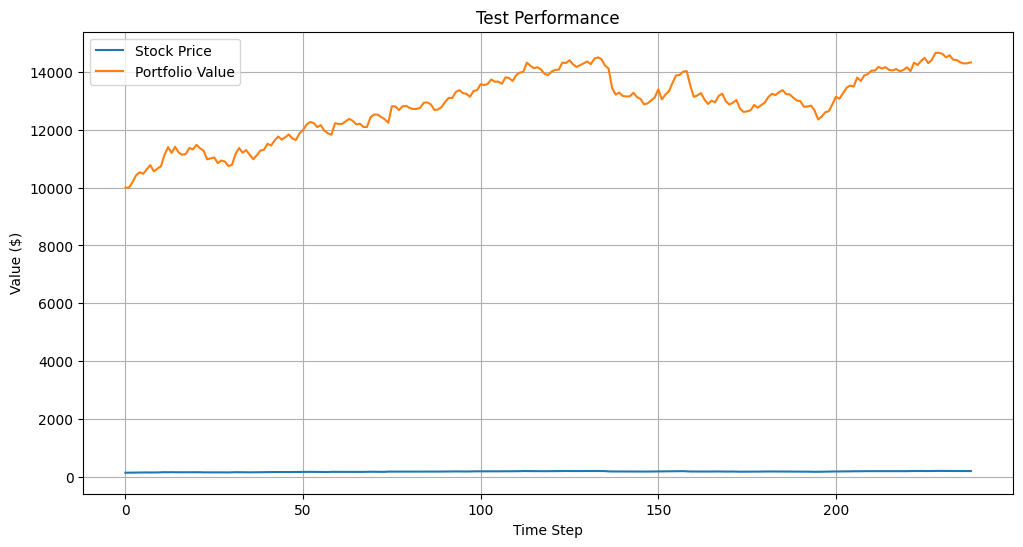

Initial Portfolio Value: $10000.00
Final Portfolio Value: $14338.81
Return: 43.39%


In [ ]:
# %% [markdown]
# ## 5. Evaluating the Trained Agent
#
# Let's see how our trained agent performs on unseen test data.

# %%
# Download test data (different time period)
test_ticker = 'AAPL'
test_start_date = '2023-01-01'
test_end_date = '2024-01-01'
test_data = download_data(test_ticker, test_start_date, test_end_date)

# Create test environment
test_env = TradingEnv(test_data, window_size=window_size)

# Evaluation
state = test_env.reset()
state = np.reshape(state, [state_size])
done = False
portfolio_values = []

while not done:
    # Use trained policy (no exploration)
    agent.epsilon = 0  # Disable exploration
    action = agent.act(state)

    # Execute action
    next_state, reward, done, info = test_env.step(action)
    next_state = np.reshape(next_state, [state_size])

    state = next_state
    portfolio_values.append(info['current_value'])

# Plot test performance
plt.figure(figsize=(12, 6))
plt.plot(test_data['price'].values[window_size:], label='Stock Price')
plt.plot(portfolio_values, label='Portfolio Value')
plt.title('Test Performance')
plt.xlabel('Time Step')
plt.ylabel('Value ($)')
plt.legend()
plt.grid()
plt.show()

# Calculate returns
initial_value = portfolio_values[0]
final_value = portfolio_values[-1]
returns = (final_value - initial_value) / initial_value * 100
print(f"Initial Portfolio Value: ${initial_value:.2f}")
print(f"Final Portfolio Value: ${final_value:.2f}")
print(f"Return: {returns:.2f}%")